In [ ]:
import mne
import matplotlib.pyplot as plt


SyntaxError: invalid syntax (4208377276.py, line 3)

In [5]:
# -------------------------
# 1. Load GDF file
# -------------------------
# Change this path to your actual file
file_path = "../data/raw/A01T.gdf"
raw = mne.io.read_raw_gdf(file_path, preload=True)

print("Channels:", raw.ch_names)
print("Sampling frequency:", raw.info['sfreq'])

Extracting EDF parameters from c:\Users\steve\OneDrive\Documentos\Personal Projects\DataScienceDL\data\raw\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\steve\anaconda3\envs\fresh_py310\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Channels: ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16', 'EOG-left', 'EOG-central', 'EOG-right']
Sampling frequency: 250.0


In [6]:
# -------------------------
# 2. Set channel types
# -------------------------
# First 22 = EEG, Last 3 = EOG
eeg_chs = raw.ch_names[:22]
eog_chs = raw.ch_names[22:]

raw.set_channel_types({ch: 'eeg' for ch in eeg_chs})
raw.set_channel_types({ch: 'eog' for ch in eog_chs})

<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MiB, data loaded>

In [7]:
#Match EEG channels to standard 10-20 system
mapping = {
    'EEG-Fz':  'Fz',
    'EEG-0':   'FC3',
    'EEG-1':   'FC1',
    'EEG-2':   'C1',
    'EEG-3':   'C5',
    'EEG-4':   'CP3',
    'EEG-5':   'CP1',
    'EEG-C3':  'C3',
    'EEG-6':   'FCz',
    'EEG-Cz':  'Cz',
    'EEG-7':   'CPz',
    'EEG-C4':  'C4',
    'EEG-8':   'FC4',
    'EEG-9':   'FC2',
    'EEG-10':  'C2',
    'EEG-11':  'C6',
    'EEG-12':  'CP4',
    'EEG-13':  'CP2',
    'EEG-14':  'P3',
    'EEG-Pz':  'Pz',   # already matches
    'EEG-15':  'P1',
    'EEG-16':  'P4',
    # EOG channels — keep or rename for clarity
    'EOG-left':     'EOG1',
    'EOG-central':  'EOG2',
    'EOG-right':    'EOG3',
}


In [25]:
# Check channel names
print("Before rename:", raw.ch_names)

# Only rename if expected keys are present
if any(ch.startswith("EEG-") for ch in raw.ch_names):
    raw.rename_channels(mapping)
    print("Renamed to:", raw.ch_names)
else:
    print("No renaming needed — already in standard format.")

Before rename: ['Fz', 'FC3', 'FC1', 'C1', 'C5', 'CP3', 'CP1', 'C3', 'FCz', 'Cz', 'CPz', 'C4', 'FC4', 'FC2', 'C2', 'C6', 'CP4', 'CP2', 'P3', 'Pz', 'P1', 'P4', 'EOG1', 'EOG2', 'EOG3']
No renaming needed — already in standard format.


In [26]:
# -------------------------
# 3. Set montage (10-20 cap)
# -------------------------

montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MiB, data loaded>

In [27]:
# -------------------------
# 4. Re-reference EEG
# -------------------------
raw.set_eeg_reference('average', projection=True)

EEG channel type selected for re-referencing


C:\Users\steve\AppData\Local\Temp\ipykernel_26156\2023854033.py:4: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)


<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MiB, data loaded>

In [17]:
# -------------------------
# 5. Filtering
# -------------------------
# ICA works better without slow drifts or high-frequency noise
raw.filter(l_freq=1., h_freq=40.)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



<RawGDF | A01T.gdf, 25 x 672528 (2690.1 s), ~128.3 MiB, data loaded>

In [22]:
# -------------------------
# 6. Run ICA
# -------------------------
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter='auto')
# Apply the average reference projection before ICA
raw.apply_proj()
# Fit ICA on EEG channels only (exclude EOG from the decomposition)
ica.fit(raw.copy().pick_types(eeg=True))

Projections have already been applied. Setting proj attribute to True.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 22 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 20 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 16.7s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,39 iterations on raw data (672528 samples)
ICA components,20
Available PCA components,22
Channel types,eeg
ICA components marked for exclusion,—


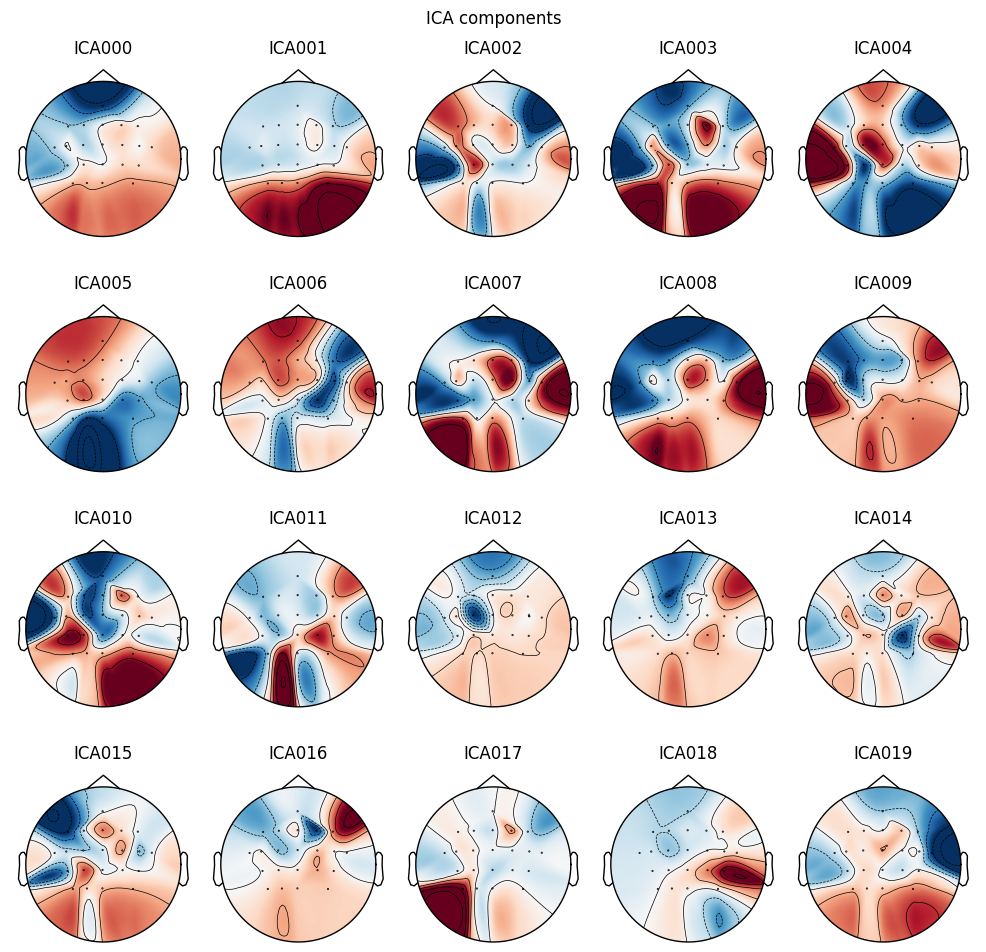

    Applying projection operator with 1 vector (pre-whitener application)
Creating RawArray with float64 data, n_channels=23, n_times=672528
    Range : 0 ... 672527 =      0.000 ...  2690.108 secs
Ready.
Using matplotlib as 2D backend.


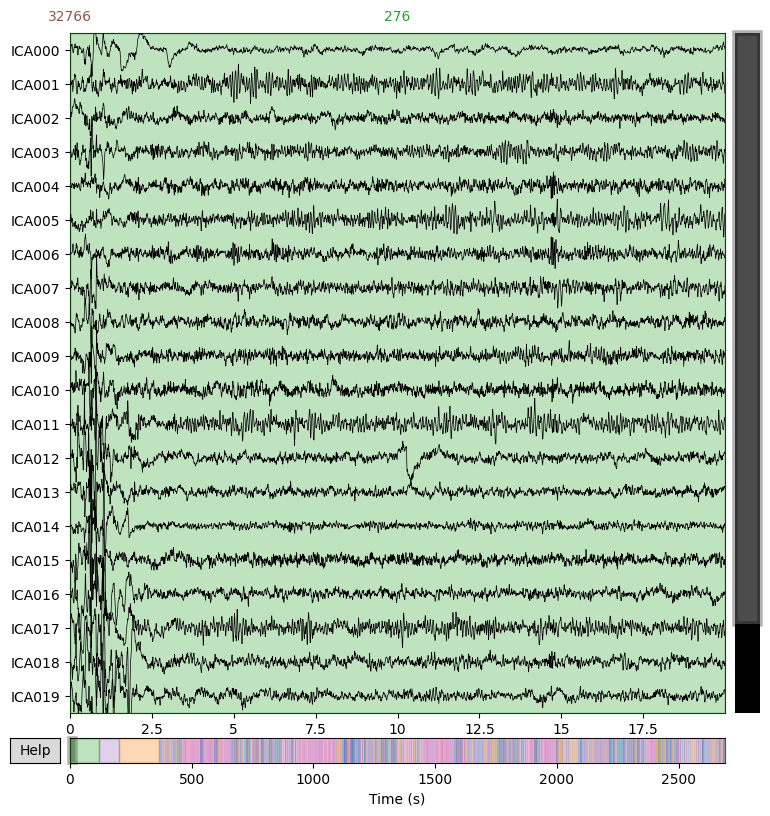

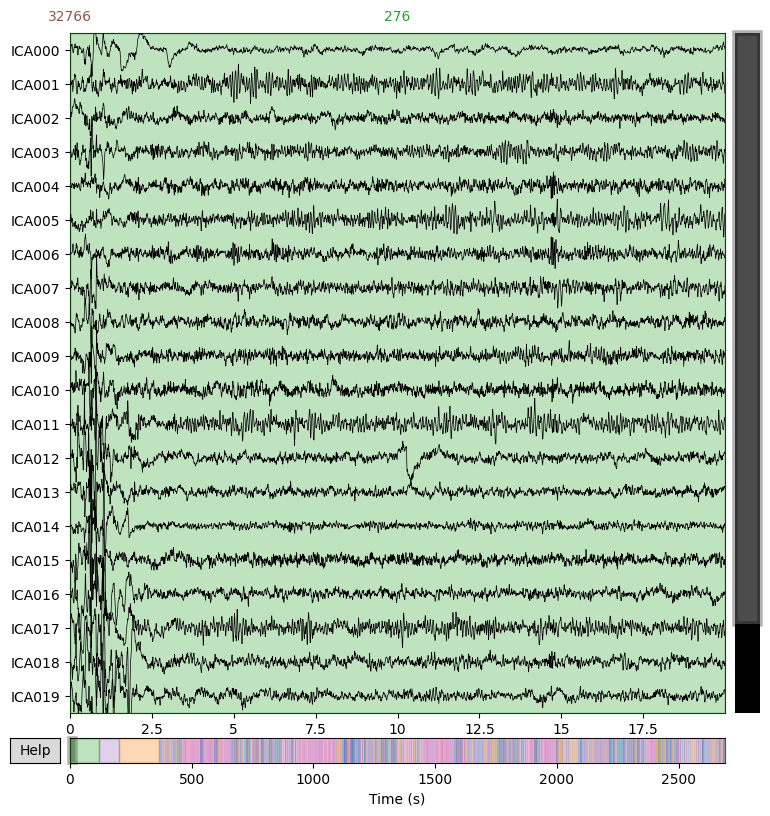

In [23]:
# -------------------------
# 7. Plot ICA components
# -------------------------
ica.plot_components()  # topographic maps
ica.plot_sources(raw)  # time series per component

Using EOG channels: EOG1, EOG2, EOG3
    Applying projection operator with 1 vector (pre-whitener application)
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edg

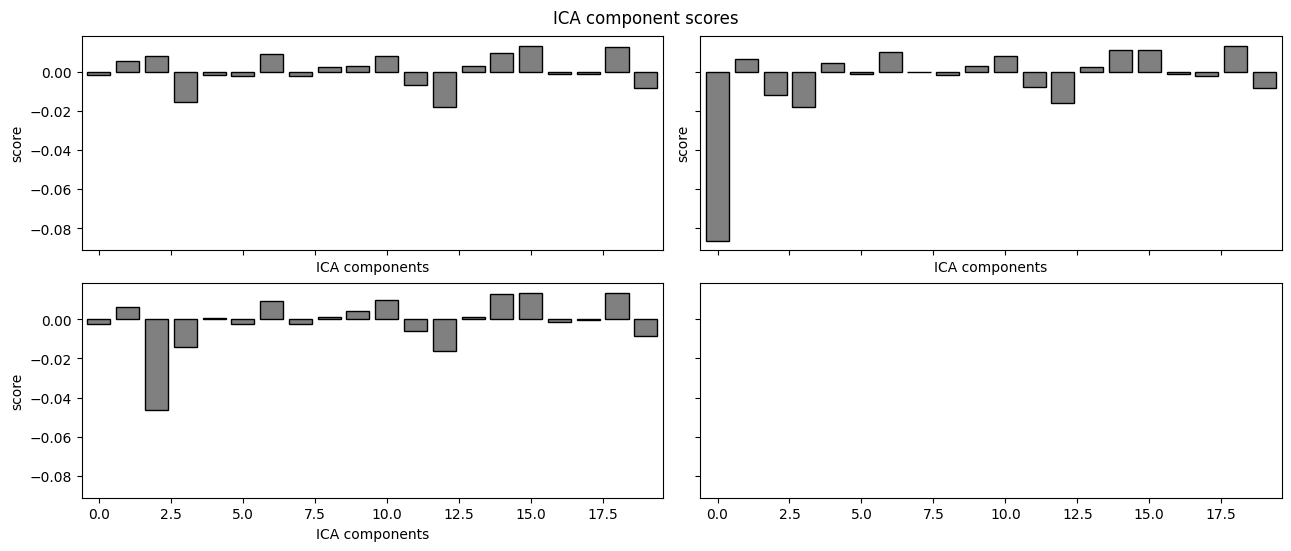

    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1345 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1345 matching events found
No baseline correction applied
0 projection items activated


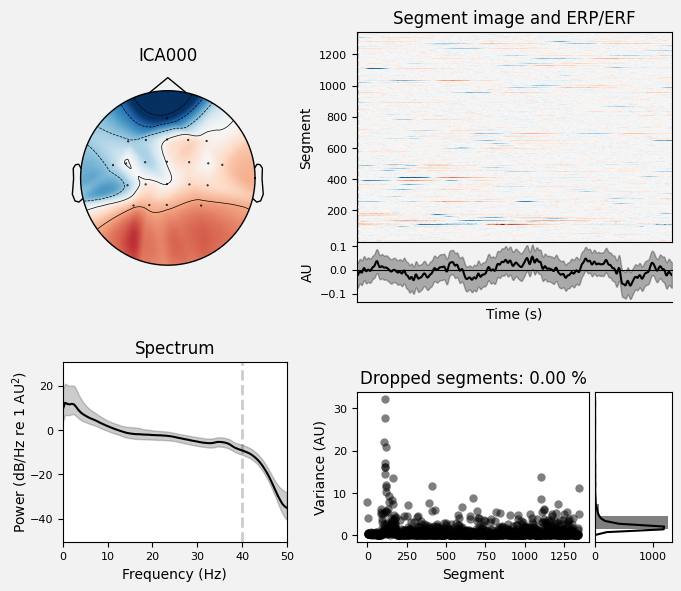

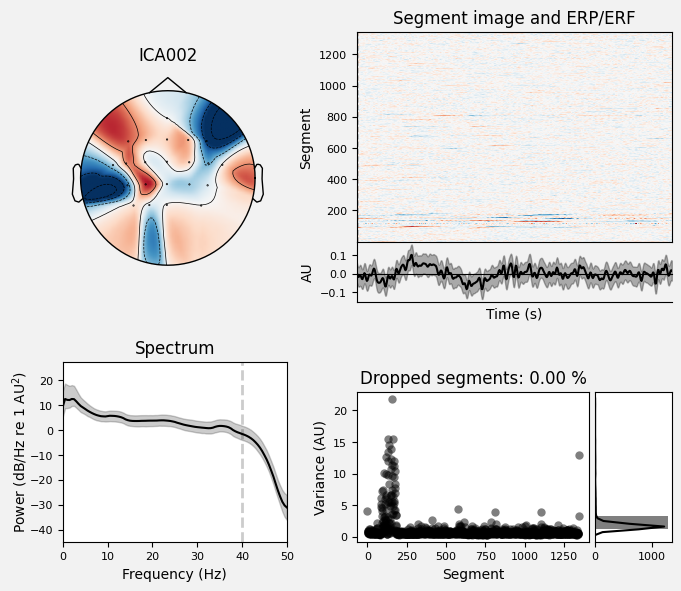

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [24]:
#Identify EOG artifacts automatically
eog_inds, eog_scores = ica.find_bads_eog(raw) # This still works even though ICA was fit on EEG only
print("EOG components:", eog_inds)

ica.plot_scores(eog_scores)  # Scores for each component
ica.plot_properties(raw, picks=eog_inds)  # Time & freq properties